In [1]:
# %pip install xmltodict

NOTES: 
- __Task__: generate a dataset to test LLM for temporal relation extraction and reasoning.
- __Ideal outcome__: Input a text, the model can generate a timeline to show the clincial events over time.
- __Information in dataset__:
    - Each document in the data has at least two key dates, admission and discharge dates.
    - Two types of tempral relations: implicit relations between events and explicit relations (i.e., at least one event has known date) between events and section_time.
    - The key idea is to combine implicit and explicit relatioins to infer a timeline of clinical events, such as 'PROBLEM', 'TEST', 'TREATMENT', like:
        1. 2020 Jan: Problem appears
        2. 2020 Feb. Test
        3. 2020 Feb: admission
        4. 2020 March. Diagnosis
        5. 2020 March. Treatment
    - Conceptual diagram: https://excalidraw.com/#json=d_zqjvbhTqdiIZvLhk-fc,0FwYqte6gJn8cW36Cbm3mQ
    - By default, all events in "History of Present Illness" should happen before events in the rest sections.
- __Data curation__: split admission and discharge secttime links. Each section would have two types of timelins:
    - Coarse grained timeline: organize events before, overlap and after the admission/dishcarge date.
    - Fine grained timeline: organize events within each section of "before"/"after"/"overlap". 

In [2]:
# HISTORY OF PRESENT ILLNESS :
# Saujule Study is a 77-year-old woman with a history of obesity and hypertension who presents with increased shortness of breath x 5 days .
# Her shortness of breath has been progressive over the last 2-3 years .
# She has an associated dry cough but no fevers , chills , or leg pain .
# She has dyspnea on exertion .
# She ambulates with walker and a cane secondary to osteoarthritis .
# She becomes short of breath just by getting up from her chair and can only walk 2-3 steps on a flat surface .
# She feels light headed when getting up .
# Her shortness of breath and dyspnea on exertion has been progressive for the past several years .
# It has not been sudden or acute .
# She sleeps in a chair up right for the last 2 1/2 years secondary to osteoarthritis .
# She has orthopnea as well but noparoxysmal nocturnal dyspnea .
# She occasionally feels chest twinges which are nonradiating but are sharp .
# They last a few seconds on the left side and are not associated with sweating , nausea , vomiting or syncope .
# She has had lower extremity edema for thelast several years with multiple episodes of cellulitis .
# Her lower extremity edema has increased for the several weeks prior to admission secondary to an inability to elevate her legs due to a broken chair at home .
# She denies any pleural chest pain .

In [2]:
import xmltodict, json
import os
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
import json

In [3]:
pd.options.display.max_columns = None

### Load data

In [4]:
# Change to path to the data
# path = '/home/wt/Downloads/n2c2 2012/'
path = 'data/i2b2/'
training_data_path = path + 'merge_training'
test_data_path = path + 'ground_truth/merged_xml'

In [5]:
def data_loader(data_path):
    data = {}
    for filename in os.listdir(data_path):
        if filename.endswith(".xml"): 
            f = (os.path.join(data_path, filename))
#             print(f)
            fb = open(f, "rb").read().decode(encoding="utf-8")
#     invalid character '&' https://github.com/martinblech/xmltodict/issues/277
            fb = fb.replace('&', '&amp;')
            dic = xmltodict.parse(fb, attr_prefix='')
#     restore orginal character "&"
            dic['ClinicalNarrativeTemporalAnnotation']['TEXT'] = dic['ClinicalNarrativeTemporalAnnotation']['TEXT'].replace('&amp;', '&')
            data[filename] = (dic)
    return data

In [6]:
train_data = data_loader(training_data_path)
test_data = data_loader(test_data_path)

In [7]:
print(len(train_data), len(test_data))

190 120


### General rules in data annotations: 
The EVENTs in clinical history need to be related to the Admission date, and the
EVENTs in hospital course need to be related to the Discharge date.

To avoid conflict, only one TLINK is allowed between the same pair of entities, e.g. EVENT A cannot be BEFORE and DURING EVENT B at the
same time

Clinical Events: indicate which of the three categories (tests /problems /treatment ) 

sec_time_rel attribute records whether the EVENT happens before, after or whether it overlaps with the section creation time

### Event attributes:
#### Type
six EVENT types to categorize different kinds of EVENTs: TEST, PROBLEM, TREATMENT, CLINICAL_DEPT, EVIDENTIAL and OCCURRENCE.

- The first three values correspond to different categories of clinical concept EVENTs (clinical tests, symptoms, diagnoses, medications, surgeries and so on).
- The CLINICAL_DEPT value is used to mark the clinical units that the patient is admitted into.
- The EVIDENTIAL type is for EVENTs that have an ‘evidential’ nature, that is, if the EVENT describes the source of the information (e.g. CT [shows], the patient [complained] and so on).
- If an EVENT does not fall in to the above five categories, it will be marked as an “occurrence” – OCCURRENCE is the default value for EVENT type.
- TEST, PROBLEM, and TREATMENT EVENTs will be pre-annotated, based on previous manual annotation of clinical concepts in this data.


#### Polarity
- POS: Most of the EVENTs have POS polarity value, that is, the EVENT is not negated. 

- NEG: If an EVENT is negated by words such as “not”, “deny”, and so on, its polarity is NEG.

#### Modality
The modality attribute is used to describe whether an EVENT actually occurred or not.

- Factual: This value is assigned to facts, i.e. EVENTs that actually happened (is happening, or will
happen). For EVENTs with NEGATIVE polarity, this value corresponds to the situation when something did not happen (is not happening, or will not happen). The default value for the modality attribute is FACTUAL.

- CONDITIONAL: This value is assigned to EVENTs that are hypothesized to happen under certain conditions.

- POSSIBLE: This value is assigned to EVENTs that are hypothesized to have occurred.

- PROPOSED: The “PROPOSED” modality type is assigned to EVENTs that are proposed or suggested but may or
may not actually happen. 

### Temporal Expressions TIMEX3:
The type attribute has four possible values: DATE, TIME, DURATION and FREQUENCY.

#### Mod
1. “NA”: the default value, no relevant modifier is present;
2. “MORE”, means “more than”, e.g. over 2 days (val = P2D, mod = MORE);
3. “LESS”, means “less than”, e.g. almost 2 months (val = P2M, mod=LESS);
4. “APPROX”, means “approximate”, e.g. nearly a week (val = P1W, mod=APPROX);
5. “START”, describes the beginning of a period of time, e.g. Christmas morning,
2005 (val= 2005-12-25, mod= START).
6. “END”, describes the end of a period of time, e.g. late last year, (val = 2010, mod
= END)
7. “MIDDLE”, describes the middle of a period of time, e.g. mid-September 2001 (val
=2001-09, mod= MIDDLE)

### TLINK:
explicit: The explicit attribute specifies whether the temporal relation is explicitly stated in the text, or is an inference made by the annotator.

type: what kind of temporal relation exists between the two entities. In our annotation, we will use eight types of temporal relations: before, after, simultaneous, overlap, begun_by, ended_by, during, and before_overlap.

SIMULTANEOUS and OVERLAP TLINK types will be merged because of the difficulty for annotators to distinguish them. 

- BEFORE, ENDED_BY, and BEFORE_OVERLAP  --> BEFORE

- BEGUN_BY and AFTER --> AFTER

- SIMULTANEOUS, OVERLAP, and DURING --> OVERLAP
- Some links have empty labels. To delete

### SECTIME Links:
Two types of section times: “ADMISSION” and “DISCHARGE”: 
- The “ADMISSION” SECTIME is used in the “History of Present Illness” section of the discharge summary. In other words, for all the EVENTs in the patient’s medical history section, the EVENT’s sec_time_rel specifies its relation to the admission date. 

- For all the other sections in the discharge summary, the “DISCHARGE” SECTIME is used, i.e. the sec_time_rel attribute for every EVENT specifies its relation to the discharge date.


where OVERLAP can have reversed links

we do not need to mark duplicate relations. 


## 1. Data distribution

In [9]:
data = train_data
link_df = []
for doc_id in list(data.keys()):
    text = data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TEXT']
    
    # Only links between events
    links = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TLINK'])
    # print('Orginal link count:', len(links))
    links = links.loc[links['id'].str.lower().str.contains('sectime')==False]
    # print('link count exclude section links:', len(links))

    
    # There are some links with empty labels
    links = links.loc[links['type']!='']

    times = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TIMEX3'])
    events = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['EVENT'])

    starts = dict(zip(events['id'], events['start'])) | dict(zip(times['id'], times['start']))
    ends = dict(zip(events['id'], events['end'])) | dict(zip(times['id'], times['end']))

    # All links
    # print(links.shape)
    links['from_start'] = links['fromID'].map(starts)
    links['from_end'] = links['fromID'].map(ends)
    links['to_start'] = links['toID'].map(starts)
    links['to_end'] = links['toID'].map(ends)
    links['span1'] = (links['from_start'].astype(int) - links['to_end'].astype(int)).abs()
    links['span2'] = (links['to_start'].astype(int) - links['from_end'].astype(int)).abs()
    links['span'] = np.maximum(links['span1'], links['span2'])
    
    link_df.append(links)

In [10]:
link_df = pd.concat(link_df, axis=0)

In [11]:
link_df.shape

(17636, 13)

In [12]:
# link_df.head()

In [13]:
link_df['type'].unique()

array(['OVERLAP', 'BEFORE', 'AFTER'], dtype=object)

In [14]:
link_df['type'].value_counts()

type
OVERLAP    11479
BEFORE      3568
AFTER       2589
Name: count, dtype: int64

**NOTE: TODO combine BEFORE and AFTER to reduce data imbalance**

In [15]:
link_df.sample(5)

,id,fromID,fromText,toID,toText,type,from_start,from_end,to_start,to_end,span1,span2,span
119,TL64,E49,orthopnea,E48,chest pain,OVERLAP,1406,1415,1393,1403,3,22,22
104,TL196,E162,steroids,E160,Nebs,OVERLAP,3615,3623,3584,3588,27,39,39
0,TL0,E0,ADMISSION,T1,02/01/2000,OVERLAP,1,10,18,28,27,8,27
36,TL42,E35,transfused blood,E30,autotransfused,OVERLAP,1191,1207,1025,1039,152,182,182
37,TL131,E65,Acyclovir,E64,positive herpes simplex virus,AFTER,4049,4058,3988,4017,32,70,70


In [16]:
len('Her lipids were checked with a total cholesterol of 110 , triglycerides 59 , HDL32 , LDL 64 .')

93

In [17]:
# How many characters between two events: about two setences. 
link_df['span'].describe()

count    17636.000000
mean       224.097584
std        601.367178
min          4.000000
25%         34.000000
50%         54.000000
75%        121.000000
max       8858.000000
Name: span, dtype: float64

In [18]:
link_df['type'].unique()

array(['OVERLAP', 'BEFORE', 'AFTER'], dtype=object)

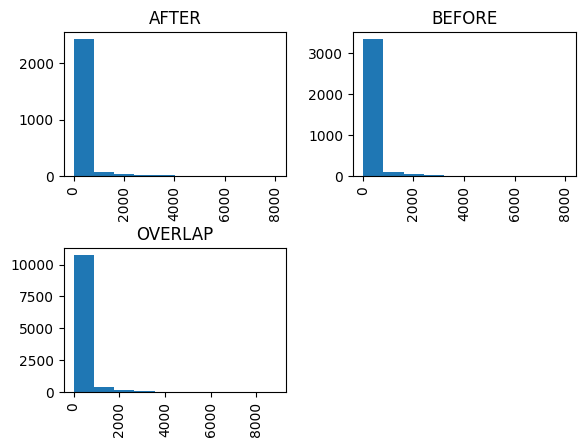

In [19]:
link_df[['span', 'type']].hist(column=["span"], by="type")
plt.show()

In [40]:
data = train_data
times_df = []
for doc_id in list(data.keys()):
    times = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TIMEX3'])
    times['did'] = doc_id
    times = times.loc[times['type'].isin(['DATE', 'DURATION', ''])]
    times_df.append(times)

In [41]:
time_df = pd.concat(times_df, axis=0)

In [42]:
# time_df

In [48]:
time_df[['text', 'val', 'did']].sample(10)

,text,val,did
22,early AM,2016-03-23,517.xml
6,day of life four,2012-09-29,707.xml
34,01-24,2019-01-24,153.xml
4,05/16/2004,2004-05-16,786.xml
5,a few seconds,P5S,596.xml
3,the 24 hours,p24h,301.xml
23,07-17,2017-07-17,472.xml
10,the day,1995-04-06,291.xml
2,2010-08-26,210-08-26,68.xml
21,two months,p2m,631.xml


## 2. Timeline network

In [339]:
def build_graph(doc_id, data):
    # for doc_id in list(data.keys())[:1]:
    text = data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TEXT']
    
    events = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['EVENT'])
    # FILTER 1: only use events related to medical concepts
    # events = events.loc[events['type'].isin(['PROBLEM', 'TEST', 'TREATMENT'])]
    event_types = dict(zip(events['id'], events['type']))
    
    # Remove duplicated admission and discharge time.
    # adm_dis = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['SECTIME'])
    times = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TIMEX3'])
    time_types = dict(zip(times['id'], times['type']))
    
    # nodes_keep = list(events['id']) + list(times['id'])
    
    links = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TLINK'])
    links = links.loc[links['type']!='']
    
    # FILTER 2: Exclude sectime links
    # links = links.loc[links['id'].str.lower().str.contains('sectime')==False]
    
    
    # Normalize AFTER and BEFORE relations
    mask = links['type'] == 'AFTER'
    links.loc[mask, ['fromID', 'fromText', 'toID', 'toText']] = links.loc[mask, ['toID', 'toText', 'fromID', 'fromText']].values
    links.loc[mask, 'type'] = 'BEFORE'
    links = links.drop_duplicates(subset=['fromID', 'fromText', 'toID', 'toText', 'type'], keep='last')
    
    
    # print(links)
    G = nx.from_pandas_edgelist(links[['fromID', 'toID', 'type']], source='fromID', target='toID', edge_attr=True, create_using=nx.DiGraph())
    source_nodes = dict(zip(links['fromID'], links['fromText']))
    target_nodes = dict(zip(links['toID'], links['toText']))
    nx.set_node_attributes(G, source_nodes|target_nodes, 'text')
    nx.set_node_attributes(G, event_types|time_types, 'type')
    # only keep nodes of interest
    # FILTER 3: only subgraph
    # G = G.subgraph(nodes_keep).copy()
    
    # clear reverse links and reduce redundent nodes; 
    # There are no many duplicated links
    return G

In [340]:
# links
# events
# times

In [341]:
G = build_graph('36.xml', train_data)

In [342]:
print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph with 189 nodes and 346 edges


In [140]:
# Graph with 189 nodes and 349 edges
# Use all available information and can choose the scope in the answer
# nx.write_graphml(G, "temp_graph.graphml")

# Ingore below ideas as it would create many disconnected nodes
# Graph with 149 nodes and 235 edges
# nx.write_graphml(G, "temp_graph_clinical_event.graphml")

# Graph with 148 nodes and 104 edges
# nx.write_graphml(G, "temp_graph_clinical_event_tlink_only.graphml")

In [141]:
# Example:
# She will be discharged on Lisinopril with further titration as an outpatient .
# <TLINK id="TL121" fromID="E142" fromText="Lisinopril" toID="E141" toText="discharged" type="BEFORE" />
# <TLINK id="TL122" fromID="E142" fromText="Lisinopril" toID="E143" toText="further titration" type="BEFORE" />

### When some non-clinical nodes removed, some time nodes are isolated. SO keep them until the last output step
Some unimportant nodes can be useful to infer paths for other important nodes. 

SO: keep all nodes. 
Just combine 'after' and 'before' together. 


How to align: 

Path: inducible ischemia -> subsequent dobutamine MIBI -> a poor study -> 02/08/2002

Edges: BEFORE -> AFTER -> BEFORE


In [25]:
# longest_path_length = nx.dag_longest_path_length(G)

In [26]:
# Graph contains a cycle or graph changed during iteration 
# longest_path_length = nx.dag_longest_path_length(G)

In [230]:
print("All paths in the graph with labels:")
for source in G.nodes:
    for target in G.nodes:
        if source != target:
            # Get all simple paths
            paths = list(nx.all_simple_paths(G, source=source, target=target))
            for path in paths:
                # Convert node IDs to their labels
                # print(path)
                if len(path)>20:
                    nodes_types = [G.nodes[node]["type"] for node in path]
                    node_labels = [G.nodes[node]["text"] for node in path]
    
                    # Find edges along the path and get their labels
                    edge_labels = [
                        G.edges[path[i], path[i + 1]]["type"]
                        for i in range(len(path) - 1)
                    ]
                    # Print the path with labels
                    if len(set(['PROBLEM', 'TEST', 'TREATMENT']).intersection(set(nodes_types)))>0:
                        print(f"Path: {' -> '.join(node_labels)}")
                        print(f"Path: {' -> '.join(nodes_types)}")
                        print(f"Edges: {' -> '.join(edge_labels)}")
                        print()

- There is no path linking all events together.
- There is a loop in the network so there is not the longest path

In [32]:
print(list(G.nodes(data=True))[:10])

print(list(G.edges(data=True))[:10])

[('E116', {'text': 'admission', 'type': 'OCCURRENCE'}), ('E0', {'text': 'Admission', 'type': 'OCCURRENCE'}), ('E65', {'text': 'cellulitis on her legs', 'type': 'PROBLEM'}), ('E71', {'text': 'her cellulitis', 'type': 'PROBLEM'}), ('E24', {'text': 'The diuresis', 'type': 'TREATMENT'}), ('E87', {'text': 'backed off', 'type': 'OCCURRENCE'}), ('E33', {'text': 'a small right common femoral clot', 'type': 'PROBLEM'}), ('E32', {'text': 'lower extremity non-invasive studies', 'type': 'TEST'}), ('E34', {'text': 'A TTE', 'type': 'TEST'}), ('E131', {'text': 'showed', 'type': 'EVIDENTIAL'})]
[('E116', 'E0', {'type': 'OVERLAP'}), ('E116', 'T0', {'type': 'OVERLAP'}), ('E0', 'T0', {'type': 'OVERLAP'}), ('E0', 'E85', {'type': 'OVERLAP'}), ('E65', 'E71', {'type': 'OVERLAP'}), ('E65', 'E69', {'type': 'BEFORE'}), ('E65', 'T1', {'type': 'BEFORE'}), ('E71', 'T1', {'type': 'BEFORE'}), ('E24', 'E87', {'type': 'OVERLAP'}), ('E24', 'T10', {'type': 'OVERLAP'})]


# Network purge

### Merge overlap nodes

In [302]:
# cut_edges = nx.minimum_edge_cut(G)

In [307]:
def merge_overlapping_nodes(G):
    """
    Merge nodes that are connected by edges with type='overlp'.
    Only merges edges across merged groups if they have the same direction.
    Maintains node attributes and edge attributes as JSON strings for GraphML compatibility.
    Tracks source nodes for each merged edge.
    
    Args:
        G (nx.Graph or nx.DiGraph): Input graph
        
    Returns:
        nx.Graph or nx.DiGraph: New graph with merged nodes and edges
    """
    # Create new merged graph of same type as input
    merged_G = G.__class__()
    
    # Find connected components considering only overlap edges
    overlap_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'OVERLAP']
    overlap_graph = nx.Graph()  # Undirected for finding components
    overlap_graph.add_edges_from(overlap_edges)
    
    # Get clusters of nodes to merge
    clusters = list(nx.connected_components(overlap_graph))
    
    # Create mapping from original nodes to their merged cluster names
    node_to_cluster = {}
    for cluster in clusters:
        cluster = list(cluster)
        merged_name = '+'.join(sorted(cluster))
        for node in cluster:
            node_to_cluster[node] = merged_name
    
    # Process nodes
    for cluster in clusters:
        cluster = list(cluster)
        
        if len(cluster) == 1:
            # Single node, just copy it and its attributes
            node = cluster[0]
            merged_G.add_node(node, **G.nodes[node])
            continue
            
        # Create merged node name
        merged_node = '+'.join(sorted(cluster))
        
        # Combine node attributes and convert to JSON string
        merged_attrs = {
            'original_nodes': json.dumps(cluster),
            'node_attributes': json.dumps({node: dict(G.nodes[node]) for node in cluster})
        }
        
        # Add merged node
        merged_G.add_node(merged_node, **merged_attrs)
    
    # Add nodes that weren't in any cluster
    unclustered_nodes = set(G.nodes()) - set(node for cluster in clusters for node in cluster)
    for node in unclustered_nodes:
        merged_G.add_node(node, **G.nodes[node])
        node_to_cluster[node] = node  # Map to itself
    
    # Create a dictionary to store edges between clusters
    cluster_edges = {}  # (from_cluster, to_cluster) -> list of original edges with source info
    
    # Process edges
    for u, v, data in G.edges(data=True):
        # Get cluster names (or original names for unclustered nodes)
        u_cluster = node_to_cluster[u]
        v_cluster = node_to_cluster[v]
        
        # Skip internal edges of merged clusters if they were overlap edges
        if u_cluster == v_cluster and data.get('type') == 'OVERLAP':
            continue
        
        # Add source node information to edge data
        edge_data = data.copy()
        edge_data['source_nodes'] = {'from': u, 'to': v}
        
        # Create edge key based on direction
        edge_key = (u_cluster, v_cluster)
        
        # For directed graphs, maintain direction information
        if isinstance(G, nx.DiGraph):
            if edge_key not in cluster_edges:
                cluster_edges[edge_key] = []
            cluster_edges[edge_key].append((u, v, edge_data))
        else:
            # For undirected graphs, normalize the edge key
            normalized_key = tuple(sorted([u_cluster, v_cluster]))
            if normalized_key not in cluster_edges:
                cluster_edges[normalized_key] = []
            cluster_edges[normalized_key].append((u, v, edge_data))
    
    # Add merged edges to the graph
    for (from_cluster, to_cluster), edges in cluster_edges.items():
        # For directed graphs, check if all edges have the same direction
        if isinstance(G, nx.DiGraph):
            # Check if all edges go in the same direction
            directions = set((u_cluster, v_cluster) 
                           for u, v, _ in edges
                           for u_cluster, v_cluster in [(node_to_cluster[u], node_to_cluster[v])])
            
            if len(directions) == 1:  # All edges have same direction
                merged_G.add_edge(from_cluster, to_cluster, 
                                edge_attributes=json.dumps([data for _, _, data in edges]))
        else:
            # For undirected graphs, just add the edge
            merged_G.add_edge(from_cluster, to_cluster, 
                            edge_attributes=json.dumps([data for _, _, data in edges]))
    
    return merged_G

def load_merged_graph(graphml_file):
    """
    Load a merged graph from GraphML file and convert JSON string attributes back to Python objects.
    """
    G = nx.read_graphml(graphml_file)
    
    # Convert node attributes back from JSON
    for node in G.nodes():
        if 'original_nodes' in G.nodes[node]:
            G.nodes[node]['original_nodes'] = json.loads(G.nodes[node]['original_nodes'])
            G.nodes[node]['node_attributes'] = json.loads(G.nodes[node]['node_attributes'])
    
    # Convert edge attributes back from JSON
    for u, v in G.edges():
        if 'edge_attributes' in G[u][v]:
            G[u][v]['edge_attributes'] = json.loads(G[u][v]['edge_attributes'])
    
    return G

# # Example usage
# def create_example_graph():
#     # Create a directed graph for testing
#     G = nx.DiGraph()
    
#     # Add nodes with attributes
#     G.add_node('A', weight=1)
#     G.add_node('B', weight=2)
#     G.add_node('C', weight=3)
#     G.add_node('D', weight=4)
#     G.add_node('E', weight=5)
    
#     # Add edges with attributes
#     G.add_edge('A', 'B', type='overlp', weight=1)
#     G.add_edge('B', 'C', type='normal', weight=2)
#     G.add_edge('C', 'D', type='overlp', weight=3)
#     G.add_edge('A', 'E', type='normal', weight=4)
#     G.add_edge('E', 'C', type='normal', weight=5)
    
#     return G

# # Test the function
# if __name__ == "__main__":
#     G = create_example_graph()
#     merged_G = merge_overlapping_nodes(G)
    
#     # Save to GraphML
#     nx.write_graphml(merged_G, "temp_graph_merged_overlap.graphml")
    
#     # Load and convert back
#     loaded_G = load_merged_graph("temp_graph_merged_overlap.graphml")
    
#     print("Original nodes:", G.nodes(data=True))
#     print("Merged nodes:", loaded_G.nodes(data=True))
#     print("Original edges:", G.edges(data=True))
    
#     # Print merged edges with source information
#     print("\nMerged edges with sources:")
#     for u, v, data in loaded_G.edges(data=True):
#         print(f"Edge {u} -> {v}:")
#         for edge_attr in data['edge_attributes']:
#             print(f"  From {edge_attr['source_nodes']['from']} to {edge_attr['source_nodes']['to']}")
#             print(f"  Attributes: {edge_attr}")

In [308]:
mergaed_G = merge_overlapping_nodes(G)

In [309]:
# print(list(G.nodes(data=True))[:10])
# print(list(G.edges(data=True))[:10])

In [310]:
print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph with 189 nodes and 346 edges


In [311]:
print(f"Graph with {mergaed_G.number_of_nodes()} nodes and {mergaed_G.number_of_edges()} edges")

Graph with 82 nodes and 135 edges


In [173]:
nx.write_graphml(mergaed_G, "temp_graph_merged_overlap.graphml")

### Check conflicting edges

In [312]:
def find_mutual_and_self_links(G):
    """
    Find nodes that have mutual connections (bidirectional links) and self-loops.
    
    Args:
        G (nx.Graph or nx.DiGraph): Input graph
        
    Returns:
        tuple: (mutual_pairs, self_loop_nodes)
            - mutual_pairs: set of frozensets containing pairs of nodes with mutual links
            - self_loop_nodes: set of nodes that have self-loops
    """
    mutual_pairs = []
    self_loop_nodes = []
    
    # Handle both directed and undirected graphs
    if isinstance(G, nx.DiGraph):
        # For directed graphs, find pairs of nodes with edges in both directions
        for u, v in G.edges():
            # Check for self-loops
            if u == v:
                self_loop_nodes.append(u)
            # Check for mutual links
            elif G.has_edge(v, u):
                mutual_pairs.append((u, v))
    else:
        # For undirected graphs, all connections are mutual by definition
        for u, v in G.edges():
            if u == v:
                self_loop_nodes.append(u)
            else:
                mutual_pairs.append((u, v))
    
    return mutual_pairs, self_loop_nodes


In [313]:
mutual_links, self_links = find_mutual_and_self_links(mergaed_G)

__There are two conflict edges__: in 36.xml, mutual and self links indicate conflicting edges. 
- Mutual links:
    - ```<TLINK id="TL179" fromID="E168" fromText="Low salt diet" toID="E165" toText="discharged" type="BEFORE" />```
    - E168 --> E165
    - ```<TLINK id="SECTIME157" fromID="E168" fromText="Low salt diet" toID="T1" toText="02/08/2002" type="AFTER" />```
    - ```<TLINK id="SECTIME153" fromID="E165" fromText="discharged" toID="T1" toText="02/08/2002" type="OVERLAP" />```
    - E165 == T1 --> E168

- Self-links:
    - ```<TLINK id="SECTIME155" fromID="E81" fromText="Discharge INR" toID="T1" toText="02/08/2002" type="BEFORE" />```
    - ```<TLINK id="TL177" fromID="E81" fromText="Discharge INR" toID="E164" toText="discharge" type="OVERLAP" />```
    - ```<TLINK id="SECTIME152" fromID="E164" fromText="discharge" toID="T1" toText="02/08/2002" type="OVERLAP" />```
    -  __E164__ === E81 --> T1 == __E164__

In [314]:
for u, v in mutual_links:
    print(u, v, mergaed_G.get_edge_data(u, v))

E130+E141+E146+E164+E165+E81+E92+T1 E145+E50+E51 {'edge_attributes': '[{"type": "BEFORE", "source_nodes": {"from": "E141", "to": "E50"}}, {"type": "BEFORE", "source_nodes": {"from": "T1", "to": "E145"}}]'}
E130+E141+E146+E164+E165+E81+E92+T1 E168+E169 {'edge_attributes': '[{"type": "BEFORE", "source_nodes": {"from": "T1", "to": "E168"}}, {"type": "BEFORE", "source_nodes": {"from": "T1", "to": "E169"}}]'}
E145+E50+E51 E130+E141+E146+E164+E165+E81+E92+T1 {'edge_attributes': '[{"type": "BEFORE", "source_nodes": {"from": "E50", "to": "T1"}}, {"type": "BEFORE", "source_nodes": {"from": "E51", "to": "T1"}}]'}
E168+E169 E130+E141+E146+E164+E165+E81+E92+T1 {'edge_attributes': '[{"type": "BEFORE", "source_nodes": {"from": "E168", "to": "E165"}}]'}


In [315]:
for u in self_links:
    print(u, u, mergaed_G.get_edge_data(u, v))

E0+E1+E107+E109+E110+E116+E119+E121+E129+E2+E3+E83+E84+E85+E95+E96+E97+E98+T0+T2+T3+T5 E0+E1+E107+E109+E110+E116+E119+E121+E129+E2+E3+E83+E84+E85+E95+E96+E97+E98+T0+T2+T3+T5 {'edge_attributes': '[{"type": "BEFORE", "source_nodes": {"from": "E84", "to": "T1"}}, {"type": "BEFORE", "source_nodes": {"from": "E121", "to": "T1"}}, {"type": "BEFORE", "source_nodes": {"from": "E129", "to": "T1"}}, {"type": "BEFORE", "source_nodes": {"from": "E85", "to": "T1"}}]'}
E130+E141+E146+E164+E165+E81+E92+T1 E130+E141+E146+E164+E165+E81+E92+T1 {'edge_attributes': '[{"type": "BEFORE", "source_nodes": {"from": "E81", "to": "T1"}}]'}


### Remove mutual_links (let other nodes decide e.g., A==B-->C-->A) and self_links (can be error as the number of before in a group is larger than self-link count)

In [316]:
def remove_self_links(G):
    H = G.copy()
    self_loops = list(nx.selfloop_edges(H))
    H.remove_edges_from(self_loops)
    return H

In [317]:
def remove_mutual_links(G):
    H = G.copy()
    edges_to_remove = set()
    
    for u, v in G.edges():
        if H.has_edge(v, u) and (v, u) not in edges_to_remove and (u, v) not in edges_to_remove:
            edge1 = G.get_edge_data(u, v)
            edge2 = G.get_edge_data(v, u)
            edges_to_remove.add((u, v))
            edges_to_remove.add((v, u))
    H.remove_edges_from(edges_to_remove)
    return H

In [318]:
mergaed_G_clean = remove_self_links(mergaed_G)

In [319]:
mergaed_G_clean2 = remove_mutual_links(mergaed_G_clean)

In [320]:
mutual_links, self_links = find_mutual_and_self_links(mergaed_G_clean)

In [321]:
mutual_links, self_links

([('E130+E141+E146+E164+E165+E81+E92+T1', 'E145+E50+E51'),
  ('E130+E141+E146+E164+E165+E81+E92+T1', 'E168+E169'),
  ('E145+E50+E51', 'E130+E141+E146+E164+E165+E81+E92+T1'),
  ('E168+E169', 'E130+E141+E146+E164+E165+E81+E92+T1')],
 [])

In [322]:
find_mutual_and_self_links(mergaed_G_clean2)

([], [])

In [323]:
print(f"Graph with {mergaed_G_clean2.number_of_nodes()} nodes and {mergaed_G_clean2.number_of_edges()} edges")

Graph with 82 nodes and 129 edges


In [287]:
nx.write_graphml(mergaed_G_clean2, "temp_graph_merged_overlap_resolve_conflict.graphml")

### Remove redundent links, keep the longest and comphrensive path. E.g., A-->B-->C delete A-->C

In [330]:
def remove_redundant_edges(G):
    redundant_edges = []
    
    # Iterate over edges while capturing their attributes
    edges = list(G.edges(data=True))  # List of tuples (u, v, data_dict)
    
    for u, v, data in edges:
        # Remove the edge and check if a path still exists
        G.remove_edge(u, v)
        
        if nx.has_path(G, u, v):
            redundant_edges.append((u, v))
        
        # Re-add the edge with its original attributes
        G.add_edge(u, v, **data)
    
    # Remove redundant edges (preserves attributes of non-redundant edges)
    G.remove_edges_from(redundant_edges)
    return G

In [331]:
mergaed_G_clean3 = remove_redundant_edges(mergaed_G_clean2)

In [332]:
print(f"Graph with {mergaed_G_clean3.number_of_nodes()} nodes and {mergaed_G_clean3.number_of_edges()} edges")

Graph with 82 nodes and 89 edges


In [329]:
nx.write_graphml(mergaed_G_clean3, "temp_graph_merged_overlap_resolve_conflict_remove_redundent.graphml")

## LLM generation

In [36]:
text[1041-1:1049-1]

'sweating'

In [37]:
from openai import OpenAI
from lmformatenforcer import JsonSchemaParser
from pydantic import BaseModel
import re, json, os
from typing import Optional, Type, TypeVar

In [38]:
# Modify OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://host.docker.internal:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)

In [39]:
chat_response = client.chat.completions.create(
    model = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B',
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Extract clinical 'PROBLEM', 'TEST', 'TREATMENT' from the text and estimate the time of each event happened." + text},
    ]
)
print("Chat response:", chat_response.choices[0].message.content)

Chat response: <think>
Okay, so I'm trying to extract the clinical PROBLEM, TEST, and TREATMENT from the given text, along with the time each event happened. Let me start by skimming through the text to understand the context.

The text is about a patient admission and hospital course. The admission date is 02/01/2002, and discharge date is 02/08/2002. So the entire stay is about a week.

First, looking at the patient's history: she's 77 years old, with obesity and hypertension. Her main complaint is increased shortness of breath for 5 days, with a progressive history over 2-3 years. She also has a dry cough, dyspnea on exertion, and orthopnea (which I think means pain from lying flat). She sleeps upright because of osteoarthritis. She has edema in her legs from several years, which causes lower extremity edema leading to cellulitis in her legs.

Her symptoms include: shortness of breath, chest twinges (sharp, on the left side), with no fever, chills, or leg pain. The dyspnea on exerti